# Lab Two: Images!
## Caleb Moore, Blake Gebhardt, Christian Gould

Data Source: https://www.kaggle.com/datasets/olavomendes/cars-vs-flowers

In [1]:
# Imports
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Notebook setup
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# 💰 Business Understanding (2 points total).
* Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 

### Purpose of the Dataset
* The purpose of the dataset is to be able to read and recognize images of automobiles and flowers. Since this is just an exercise in image processing, we decided to build something that would be able to determine the difference between a car and a flower. This is a dataset initially posted at Deep Learning with Keras Workshop and contains 2000 images of cars and 2000 images of flowers for training and testing.

### Prediction Task
* The prediction task is exactly what the dataset was originally collected for. We want to be able to predict if a given image depicts either a car or a flower. This should be a fairly simple classification task. We hope to be able to predict with an accuracy of at least 70%.

### Third Parties
* Other third parties that may be interested are companies that store the photos of users. Classifying the subject of an image would allow a user to quickly search for photos of a certain subject. Google Photos and Apple both use similar versions of this kind of image analysis. Cars are a common CAPTCHA check. If we can create a program that predicts with enough accuracy, third parties interested in bypassing anti-bot software may be interested. However, for our program to be viable, it must be able to predict correctly at least 90% of the time. It would need to be indistinguishable from a human, which is much too high of a bar. 

# 📊 Data Preparation

* [.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.

In [3]:
# Function to convert an image to a 1 dimensional array, given the image path
IMG_SIZE = 30

def conv_img_to_array(img_path):
    img = Image.open(img_path)
    # Convert to grayscale
    img = img.convert('L')

    # Adjust the size
    img = img.resize((IMG_SIZE, IMG_SIZE))

    # Convert to numpy array
    img_array = np.array(img)

    # Flatten the array
    img_array = img_array.flatten()
    return img_array

* [.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).   

In [4]:
def conv_data_folder_to_df(df, dataFolderPath, title, limit=None):

    # Create an empty list to store the image arrays
    img_array_list = []

    # Loop over all the images in the folder for limited number of them
    count = 0
    for img_path in os.listdir(dataFolderPath):
        if limit is not None and count == limit:
            break
        # Convert the image to a 1 dimensional array
        img_array = conv_img_to_array(dataFolderPath + img_path)

        # Add the suite_id, sample_id, and code to the front of the array
        img_array = np.append(title, img_array)

        # Add it to the list
        img_array_list.append(img_array)
        count += 1

    # Convert the list to a dataframe
    new_one = pd.DataFrame(img_array_list)
    return pd.concat([df,new_one], ignore_index=True)

* [.1 points] Visualize several images.

In [5]:
# Given a flattened array of pixel values, display the image
def visualize_array(img_array):
    # Reshape the array to 64x64
    img_array = img_array.reshape(IMG_SIZE, IMG_SIZE)

    # Convert the array to an image
    img = Image.fromarray(img_array)

    # Display the image
    display(img)

In [6]:
# Visualize an image
img_1 = 'smallSet/first.jpg'
img_1_arr = conv_img_to_array(img_1)
print("array form: ", img_1_arr)
visualize_array(img_1_arr)

array form:  [103  50  57  86  88  57  58 185 196 122  73  80  97  86  95  71  67  93
  72  79  96 119 161 116  69  96  99 113  81 103  88  32  33  62  56  37
 126 229 243 171  66  80  84  82  73  62 110 180  80  33  38  98 135  65
  40  33  54  54  99  68  82  34  33  71  33  27 154 207 195 199 195 202
 208 209 210 199 206 207 185 143  82  77  84  48  41  55  62  39  46  53
  83  39  40  50  32  25 131 181 163 160 163 157 156 165 176 171 174 175
 183 198 186 117  70  45  24  49  62  37  28  76  89  50  48  84  34  24
 122 111  68  79  84  83  78  84  94  86  96 100  90  89 125 144  87  48
  22  46  56  30  48 110  84  36  64  72  49  41 138  57  48  56  55  62
  62  61  63  58  67  68  70  76  90 103 118  41  24  48  52  24  63 109
 100  47  83  86 103  84 154  42  46  43  46  56  57  56  56  53  51  54
  62  64  77  79 148  53  23  54  45  27  78  53 137  86  72  80 141 123
 153  29  46  41  44  90  56  85 111  73  95  49  48  61  72  63 157  92
  19  50  35  30  40  45 123  85  69  

In [7]:
# Visualize another image
img_2 = 'smallSet/second.jpg'
img_2_arr = conv_img_to_array(img_2)
print("array form: ", img_2_arr)
print("array size: ", img_2_arr.size)
visualize_array(img_2_arr)

array form:  [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 2

In [8]:
# Visualize a final image
img_3 = 'smallSet/third.jpg'
img_3_arr = conv_img_to_array(img_3)
print("array form: ", img_3_arr)
visualize_array(img_3_arr)

array form:  [119 115 111 107 105 105 106 107 109 111 113 114 116 118 120 118 115 112
 110 107  99  93  87  83  83  84  79  63  71  65 107 112 115 118 120 122
 123 125 125 125 125 124 124 124 124 125 127 129 130 134 138 134 124 113
  98  92  87  78  79  49 102 100  97  93  88  84  80  76  73  72  71  71
  72  74  76  79  82  85  89  95 100 106 114 126 120  92  83  80  94  67
  62  61  61  61  62  63  62  63  65  67  70  71  74  76  80  83  87  90
  95  99 103 106 108 110 112  87  50  30  62 110 120 129 134 138 141 143
  77  67  69  69  71  73  74  76  78  82  88  92  98 103 108 112 116 118
 119 121 116  91  57  98 187 217 196 183 165 112  71  71  71  71  71  71
  75  85  96 106 113 118 121 122 121 122 125 127 128 139 145 137 123 132
 204 219 199 157  99  73  77  74  74  72  78  97 116 127 129 124 118 114
 114 116 120 125 129 134 137 148 151 140 128 138 176 151 119  85  84  87
  85  83  84 103 125 129 112  80  49  28  17  15  17  21  30  50  74  93
 118 134 132 132 122 126 108 110 106  

### Read in our image data and csv data

In [9]:
# Convert the data folder to a dataframe
TRAINING_DF_SIZE = 1000

df = pd.DataFrame()
df = conv_data_folder_to_df(df, './training_set/car/', 'car', TRAINING_DF_SIZE)
df = conv_data_folder_to_df(df, './training_set/flower/', 'flower', TRAINING_DF_SIZE)

# Rename the first column to target
df = df.rename({0: 'target'}, axis=1)
df.head(10)

,target,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
0,car,104,141,100,97,126,161,168,165,163,...,17,21,34,53,62,41,61,55,50,68
1,car,105,123,223,235,231,231,232,232,233,...,87,71,65,66,68,63,46,9,12,15
2,car,149,150,150,150,151,152,152,152,152,...,147,151,153,150,144,142,139,138,139,140
3,car,227,227,230,229,226,229,228,229,228,...,179,176,159,142,154,154,138,131,123,111
4,car,76,52,56,45,62,71,76,60,19,...,111,127,163,197,218,224,222,218,211,201
5,car,173,165,169,152,155,158,177,173,166,...,26,13,5,5,42,91,169,69,20,26
6,car,185,189,192,196,199,197,192,194,194,...,182,184,186,185,184,183,182,178,176,179
7,car,141,105,119,106,91,80,56,98,242,...,80,79,77,74,73,72,70,70,69,68
8,car,218,216,208,215,224,235,233,229,230,...,96,93,90,85,82,83,82,83,82,89
9,car,0,0,0,0,0,0,1,2,2,...,52,49,52,52,54,60,50,23,12,10


### Take a brief look at the data

In [10]:
print('data shape', df.shape)
print()
num_vars = df.columns [df.dtypes != 'object']
cat_vars = df.columns [df.dtypes == 'object']
print ('numerical:', num_vars.values)
print()
print('categorical:', cat_vars.values)
df.dtypes

data shape (2000, 901)

numerical: []

categorical: ['target' 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 25

target    object
1         object
2         object
3         object
4         object
           ...  
896       object
897       object
898       object
899       object
900       object
Length: 901, dtype: object

# [1.5 points] Data Reduction 👌: 
[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

### Initial PCA
* What we want to do is find just how many dimensions are necessary to adequately represent our image data. We need to look at the PCA of the data with the original number of components and go from there.
<br>
* For our image data, because the values are from 0-255, and that scale of the data is consistent among all our features, we do not need to scale the data.

In [11]:
# Standardize the data
tempdf = df.copy()

# Drop the target column, and store it for later analysis
y = tempdf['target']
x = tempdf.drop('target', axis=1)

In [12]:
pca_orig_components = PCA(n_components=(min((IMG_SIZE * IMG_SIZE), (2*TRAINING_DF_SIZE))), svd_solver='full')
principalComponents = pca_orig_components.fit_transform(x)

### Analysis of PCA
* From below, it is clear to see that as we get higher and higher in the number of components, our variance increases over time. This is because we are adding more and more dimensions to our data, and the more dimensions we add, the more variance we will have.
* We want to go for variance of around 95%, so we will go with 200 components.

Text(0, 0.5, 'Explained variance')

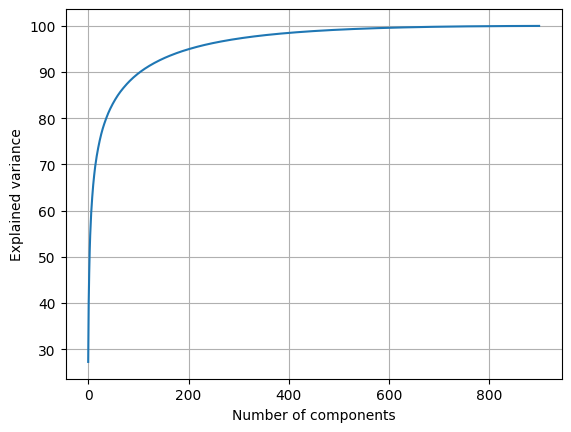

In [13]:
# Visualize the data
plt.grid()
plt.plot(np.cumsum(pca_orig_components.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

In [14]:
tempdf2 = df.copy()
x2 = tempdf2.drop('target', axis=1)

In [15]:
pca_randomized = PCA(n_components=(min((IMG_SIZE * IMG_SIZE), (2*TRAINING_DF_SIZE))), svd_solver='randomized')
principalComponents = pca_randomized.fit_transform(x2)

Text(0, 0.5, 'Explained variance')

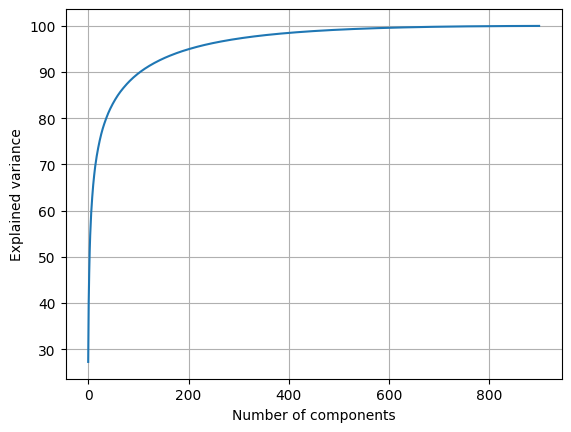

In [16]:
# Visualize the data
plt.grid()
plt.plot(np.cumsum(pca_orig_components.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

### Analysis
* When we look at the results below, we can see that the randomized PCA is able to achieve very close to what the full PCA was able to achieve in terms of variance. However, randomized PCA is much faster and memory efficient, so it is the better choice for this dataset. If we needed to squeeze out a little more variance, we could increase the number of components, but we would have to increase the time and memory it takes to run the algorithm.
* For this reason, we will be using randomized PCA and 200 components so that we can quickly achieve over 95% variance

(70.0, 100.0)

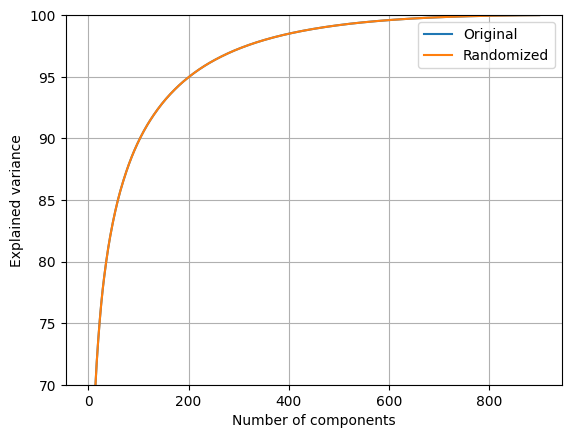

In [17]:
# Plot the two methods on top of each other in one graph
plt.grid()
plt.plot(np.cumsum(pca_orig_components.explained_variance_ratio_ * 100), label='Original')
plt.plot(np.cumsum(pca_randomized.explained_variance_ratio_ * 100), label='Randomized')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.legend()

# Zoom in on the y values 70 to 100
plt.ylim(70, 100)

*The graph above is expected to have the lines be very close, and actually is a good thing, since that means that the randomized PCA is able to achieve very close to what the full PCA was able to achieve in terms of variance. Looking at the list below, you can see that the values are very close to each other, though the randomized achieves slightly less than the full.*

In [18]:
print("cumulative variance explained by the first 900 components")
print('Full           vs         Randomized')
print('------------------------------------')
for x, y in zip(np.cumsum(pca_orig_components.explained_variance_ratio_), np.cumsum(pca_randomized.explained_variance_ratio_)):
    print(x, y)

cumulative variance explained by the first 900 components
Full           vs         Randomized
------------------------------------
0.2723557332145256 0.2723557332145257
0.3999124630409243 0.3999124630409244
0.46436587380505673 0.46436587380505673
0.5126331260389763 0.5126331260389763
0.547359269614816 0.547359269614816
0.572941501369089 0.5729415013690888
0.5954065240021449 0.5954065240021447
0.613178066495817 0.6131780664958167
0.6287782125640855 0.6287782125640853
0.6433896687450802 0.64338966874508
0.6558756502899179 0.6558756502899177
0.6673562098517425 0.6673562098517423
0.6775323670313236 0.6775323670313234
0.6870733667850581 0.6870733667850579
0.6961283978434994 0.6961283978434991
0.7040106327795933 0.704010632779593
0.7112591943313407 0.7112591943313403
0.71818847367264 0.7181884736726397
0.7245662473212362 0.7245662473212359
0.7305639084711021 0.7305639084711018
0.7363173676614057 0.7363173676614053
0.7418585503437504 0.74185855034375
0.7470572508695283 0.747057250869528
0.75

<span style="color:red">
[1 points] Perform feature extraction upon the images using DAISY. Try different parameters for your image data.
</span>

<span style="color:red">
[2 points] Does this feature extraction method show promise for your prediction task? Why?
</span>

<span style="color:red">
* Use visualizations to analyze this questions. For example, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  
</span>

# Exceptional Work (1 points total)
<span style="color:red">
(0.4) The overall quality of the report as a coherent, useful, and polished product will be reflected here. Does it make sense overall? Do your visualizations answer the questions you put forth in your business analysis? Do you properly and consistently cite sources and annotate changes made to base code? Do you provide specific reasons for your assumptions? Do subsequent questions follow naturally from initial exploration?
</span>


<span style="color:red">
(0.6) Additional analysis
(5000 level) You have free rein to provide any additional analyses and visualizations appropriate to your data.
</span>